###Download dataset


In [1]:
!mkdir dataset
!wget https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/ThoracicSurgery_test.csv -P dataset -nc
!wget https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/ThoracicSurgery_train.csv -P dataset -nc

--2021-11-30 16:01:14--  https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/ThoracicSurgery_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12981 (13K) [text/plain]
Saving to: ‘dataset/ThoracicSurgery_test.csv’

ThoracicSurgery_tes 100%[===================>]  12.68K  --.-KB/s    in 0s      

2021-11-30 16:01:14 (96.4 MB/s) - ‘dataset/ThoracicSurgery_test.csv’ saved [12981/12981]

--2021-11-30 16:01:14--  https://raw.githubusercontent.com/GiuseppeMoscarelli/Thoracic-Surgery/main/dataset/ThoracicSurgery_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

### Imports

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from imblearn.over_sampling import SMOTE



### Read Datasets

In [3]:
DATASET_PATH_TEST = Path('.') / 'dataset' / 'ThoracicSurgery_test.csv'
DATASET_PATH_TRAIN = Path('.') / 'dataset' / 'ThoracicSurgery_train.csv'


def load_dataset(train=True):
    path = DATASET_PATH_TRAIN if train else DATASET_PATH_TEST
    df = pd.read_csv(path)
    return df

### Data manipulation

In [4]:
pd.set_option('display.max_colwidth', 5000)

df_train = load_dataset(train=True)
df_test = load_dataset(train=False)

df_merged = pd.concat([df_train, df_test])

train_len = df_train.shape[0]
test_len = df_test.shape[0]
total_len = train_len + test_len

df_merged.head()

,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,Death_1yr
0,DGN4,0.131687,0.176991,PRZ0,0,0,0,0,0,OC12,0,0,0,1,0,0.727273,1
1,DGN2,0.534979,0.398230,PRZ1,0,0,0,1,0,OC12,0,0,0,1,0,0.515152,1
2,DGN3,0.106996,0.097345,PRZ1,0,0,0,1,0,OC13,0,0,0,1,0,0.727273,0
3,DGN2,0.312757,0.303097,PRZ1,0,0,0,1,0,OC11,0,0,0,1,0,0.772727,0
4,DGN3,0.419753,0.389381,PRZ1,0,1,0,0,0,OC11,0,0,0,0,0,0.484848,0


In [5]:
#Removing prefix from categorical features
def remove_prefix(df, col, prefix):
    df[col] = df[col].apply(lambda s: int(s.replace(prefix, '')))
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())  
    return df

In [6]:
remove_prefix(df_merged, 'Diagnosis', 'DGN')
remove_prefix(df_merged, 'Performance', 'PRZ')
remove_prefix(df_merged, 'Tumor_Size', 'OC')

,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,Death_1yr
0,0.428571,0.131687,0.176991,0.0,0,0,0,0,0,0.333333,0,0,0,1,0,0.727273,1
1,0.142857,0.534979,0.398230,0.5,0,0,0,1,0,0.333333,0,0,0,1,0,0.515152,1
2,0.285714,0.106996,0.097345,0.5,0,0,0,1,0,0.666667,0,0,0,1,0,0.727273,0
3,0.142857,0.312757,0.303097,0.5,0,0,0,1,0,0.000000,0,0,0,1,0,0.772727,0
4,0.285714,0.419753,0.389381,0.5,0,1,0,0,0,0.000000,0,0,0,0,0,0.484848,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.285714,0.209877,0.176991,0.5,0,0,0,1,1,0.000000,0,0,0,1,0,0.696970,0
133,0.285714,0.559671,0.592920,0.5,0,0,0,1,0,0.333333,0,0,0,1,0,0.621212,0
134,0.714286,0.806584,0.663717,0.5,0,0,0,1,0,0.333333,0,0,0,0,0,0.621212,0
135,0.142857,0.337449,0.336283,0.5,0,0,0,1,0,0.000000,0,0,0,0,0,0.424242,0


### Applying PCA

Text(0, 0.5, 'explained variance')

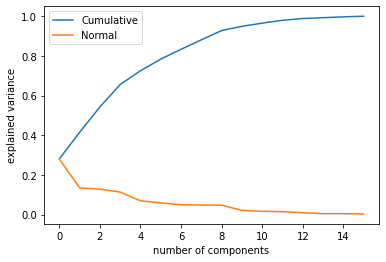

In [7]:
n_components=16
labels = df_merged.keys()
x_labels = labels[:-1]
y_label = labels[-1]

X = df_merged[x_labels]
y = df_merged[y_label]
pca = PCA(n_components=n_components, random_state=42)
pca_results = pca.fit_transform(X.values)

#Plot cumulative and proportional variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative")
plt.plot(pca.explained_variance_ratio_, label="Normal")
plt.legend()
plt.xlabel('number of components')
plt.ylabel('explained variance')


Select an adequate number of principal components

In [8]:
n_components=9
pca = PCA(n_components=n_components, random_state=42)
pca_results = pca.fit_transform(X.values)
print('>> Cumulative explained variance for {} principal components: {}'.format(
    n_components,
    np.sum(pca.explained_variance_ratio_))
)

train_pca, test_pca = np.split(pca_results, [train_len], axis=0)
train_pca_y, test_pca_y = np.split(y.values, [train_len], axis=0)



>> Cumulative explained variance for 9 principal components: 0.9278753145599087


After applying PCA we applied SMOTE on the obtained dataset

In [9]:
sm = SMOTE(random_state=42, sampling_strategy='not majority')
train_pca_smote, train_pca_smote_y = sm.fit_resample(train_pca, train_pca_y)

In [10]:
columns_names = [f"pc{i+1}" for i in range(n_components)] + [y_label]

train_pca_df = pd.DataFrame(
    np.c_[train_pca_smote, train_pca_smote_y],
    columns=columns_names)
test_pca_df = pd.DataFrame(
    np.c_[test_pca, test_pca_y],
    columns=columns_names)

train_pca_df[y_label] = train_pca_df[y_label].astype(int)
test_pca_df[y_label] = test_pca_df[y_label].astype(int)

train_pca_df.head()


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,Death_1yr
0,0.700261,-0.310428,0.231869,0.155183,0.134095,-0.116696,0.218389,-0.272984,0.056124,1
1,-0.244989,-0.249302,-0.288464,-0.020269,-0.082265,0.056222,-0.040176,0.012596,-0.121128,1
2,-0.315141,-0.184171,-0.266369,0.034101,0.158593,-0.023832,0.319476,-0.418823,-0.065517,0
3,-0.253496,-0.225830,-0.211251,-0.030107,0.004292,-0.254911,0.069165,0.151610,0.087255,0
4,0.735795,1.007484,0.112238,0.340897,-0.209617,-0.261222,-0.190015,0.132623,-0.103550,0


### Save new obtained datasets

In [11]:
TRAIN_SAVE_PATH = Path('.') / 'dataset' / 'ThoracicSurgery_pca_train.csv'
TEST_SAVE_PATH = Path('.') / 'dataset' / 'ThoracicSurgery_pca_test.csv'

train_pca_df.to_csv(TRAIN_SAVE_PATH, index=False)
test_pca_df.to_csv(TEST_SAVE_PATH, index=False)


### Result analysis

In [12]:
print(pca_results.shape)
print(pca.components_.shape)
reconstructed = np.matmul(pca_results, pca.components_)

print(reconstructed.shape)

(455, 9)
(9, 16)
(455, 16)


In [13]:
#Sample a patient from the test set (it will be useful to make an example in decision trees)
test_pca_df[-2:-1].head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,Death_1yr
135,0.049141,0.534387,-0.465535,-0.536566,-0.116037,-0.271537,0.013658,0.14084,-0.001379,0


In [14]:
eighth_component = pca.components_[7]
eighth_component

array([ 0.08232354,  0.27052835,  0.27409081,  0.1742117 ,  0.46156494,
       -0.0109055 , -0.24688166,  0.0433472 , -0.07164708, -0.70806464,
        0.16551811,  0.00161269, -0.03349487,  0.04117668, -0.01015909,
       -0.04198546])

In [15]:
print(x_labels[4])
print(x_labels[9])

Pain
Tumor_Size
